# Exploring the Value of Advantage in D&D 5e

In Dungeons & Dragons 5e, *advantage* is a core mechanic that allows a player to roll two d20s and take the higher result. This notebook explores the **value** of advantage under different assumptions, considering expected value and pass rate.

This project also aims to effectively use NumPy and MatPlotLib for calculations and visualisations. This was inspired by a Youtube video I saw [How good is Advantage in D&D?](www.youtube.com/watch?si=Jx9LH4gxhLOGG_Fx&v=R0gewfLILw0&feature=youtu.be)

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import minimize_scalar

## What is Advantage?

In D&D, a 20-sided die is rolled to determine the success of an action. After adding appropriate modifiers, the result of the roll must be equal to or greater than the Difficulty Class (DC) of the action, for the action to succeed. For a normal roll,
$$
\Pr(Success) = Pr(Dice + Modifier \ge DC)
$$

> Sometimes a special ability or spell tells you that you have advantage or disadvantage on an ability check, a saving throw, or an attack roll. When that happens, you roll a second d20 when you make the roll. Use the higher of the two rolls if you have advantage, and use the lower roll if you have disadvantage. For example, if you have disadvantage and roll a 17 and a 5, you use the 5. If you instead have advantage and roll those numbers, you use the 17.

[Typically](https://medium.com/@aking11/how-advantageous-is-advantage-in-d-d-5e-b0be28cb56a7), the result of an advantaged roll and its expected value is written like this.
$$
X = \max(a, b),
\quad
a, b \overset{\text{i.i.d.}}{\sim} \mathrm{Uniform}\{1, \dots, 20\}.
\newline
\mathbb{E}(X) = \frac{1}{20^2} \sum_{a=1}^{20} \sum_{b=1}^{20} max(a, b) \approx 13.825
$$

This should imply that advantage is roughly equivalent to a +3.325 modifier. However, since the advantaged result is non-linear, this EV does not correspond well to the actual probability of succeeding the action. Moreover, we haven't taken into account how critical successes and failures can affect rolls, as well as how the distribution of DCs in-game might affect rolls!

## How does Advantage affect the probability of success?

I'm going to simulate the effects of advantage during an attack roll in combat! Here, a natural 20 effectively guarantees a hit and allows a player to do double damage, while a natural 1 guarantees a miss and is often detrimental to the player in some way e.g. hitting an ally, falling over, etc. I've denoted the outcomes of the rolls to reflect this:

In [ ]:

{
    "Normal Success": 1,
    "Normal Failure": 0,
    "Critical Success": 2, # equivalent to two successful attack rolls
    "Critical Failure": -1 # let's have this be equivalent to shooting yourself in the foot
}

def roll(modifier: float, dc: int, dice_sides: int=20, calculate_critical: bool=False) -> float:
    rolls = np.arange(1, dice_sides + 1)
     # 1 for success, 0 for failure, fractional if modifier is fractional i.e. rolling 14 with "modifier" 0.1 should succeed 10% of the time
    success = np.clip(rolls + modifier - (dc - 1), 0, 1)
    if calculate_critical and dice_sides == 20:
        success[0], success[-1] = -1, 2
    return success.mean()

def roll_advantage(modifier: int, dc: int, dice_sides: int=20, calculate_critical: bool=False) -> float:
    rolls = np.arange(1, dice_sides + 1)
    success_matrix = (np.maximum.outer(rolls, rolls) + modifier) >= dc
    if calculate_critical and dice_sides == 20:
        success_matrix = success_matrix.astype(int)
        success_matrix[0, 0] = -1
        success_matrix[:, -1], success_matrix[-1, :] = 2, 2
    return success_matrix.mean()

def simulate_rolls(modifier: np.ndarray, dc: np.ndarray, dice_sides: int=20, calculate_critical: bool=False) -> tuple[np.ndarray, np.ndarray]:
    normal = np.array([roll(m, d, dice_sides, calculate_critical) for m in modifier for d in dc]).reshape(len(modifier), len(dc))
    advantage = np.array([roll_advantage(m, d, dice_sides, calculate_critical) for m in modifier for d in dc]).reshape(len(modifier), len(dc))
    return normal, advantage

This is really important, since advantage increases probability of critical success by 19/400, and decreases probability of critical failure by 19/400.

After plotting the increase in probability of a successful attack, we find (as expected) that advantage is most useful when there's already a high chance of success! Of course, if initial probability is already too high, advantage is slightly less useful. We also see that incorporating critical hits into our calculations increased the effect of advantage by over 10%!

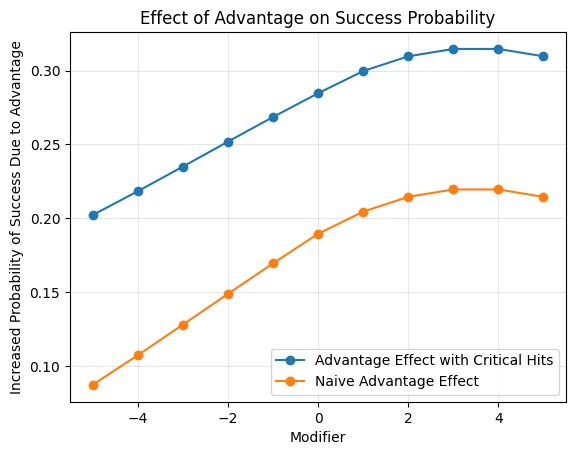

In [194]:
# AC frequencies taken from https://rpg.stackexchange.com/questions/104430/what-is-the-distribution-of-armor-classes-in-d-d-5e
# No monsters with AC < 9
ac_values = np.arange(9, 21)

normal, advantage = simulate_rolls(modifier=np.arange(-5, 6), dc=ac_values, dice_sides=20)
normal_crit, advantage_crit = simulate_rolls(modifier=np.arange(-5, 6), dc=ac_values, dice_sides=20, calculate_critical=True)
advantage_effect_control = np.mean(advantage, axis=1) - np.mean(normal, axis=1)
advantage_effect_crit = np.mean(advantage_crit, axis=1) - np.mean(normal_crit, axis=1)

plt.plot(np.arange(-5, 6), advantage_effect_crit, marker='o')
plt.plot(np.arange(-5, 6), advantage_effect_control, marker='o')
plt.legend(['Advantage Effect with Critical Hits', 'Naive Advantage Effect'])
plt.xlabel('Modifier')
plt.ylabel('Increased Probability of Success Due to Advantage')
plt.title('Effect of Advantage on Success Probability')
plt.grid(alpha=0.3)
plt.show()

In [196]:
crit_impact = advantage_effect_crit - advantage_effect_control
print(f"Impact of critical hits on advantage effect: {crit_impact.mean():.4f} ± {crit_impact.std():.4f}")

Impact of critical hits on advantage effect: 0.1004 ± 0.0070


## Can we express the effect of Advantage with an equivalent modifier?

I ran a grid search across different modifier values to see which modifiers gave a probability of success closest to the probability with an advantaged roll. Fractional probabilities don't really exist, but for my purposes, I've made it so that a +0.1 modifier has a 10% probability of acting as a +1 modifier, and a 90% probability of acting like a +0 modifier.

Plotting the results below, we have a really nice graph where the yellow ridge running diagonally across the surface mot only represents the highest edge given by advantage on a roll, but also corresponds very well to conditions typically seen in a game! There is a maximum point (where advantage acts like an additional +6.9 modifier) at Modifier +2, DC 13 in the graph, and this corresponds to a standard combat round at Level 1.

There are situations where advantage isn't very useful, like with Modifier +9 DC 9, but these situations are unlikely to actually show up in-game.

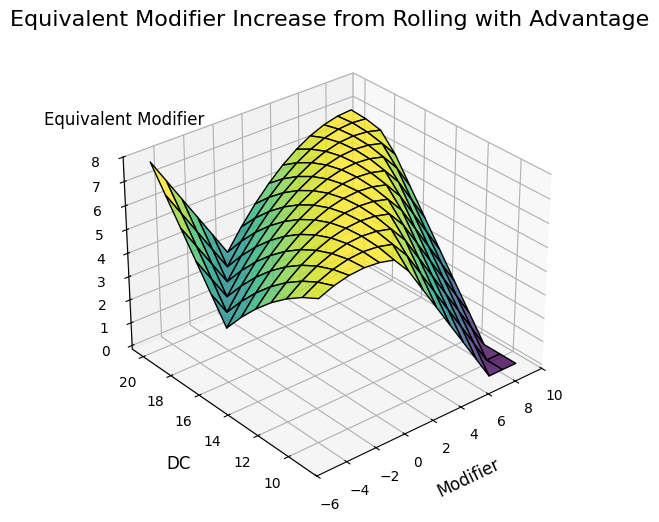

In [302]:
def equivalent_modifier(
    current_modifier: int,
    dc: int,
    bounds=(0, 20),
    dice_sides: int = 20,
    calculate_critical: bool = True,
    step: float = 0.01
) -> float:
    p_target = roll_advantage(current_modifier, dc, dice_sides, calculate_critical)

    # realised that minimise_scalar won't work well here because the function is not smooth, so we'll do a grid search instead
    candidates = np.arange(bounds[0], bounds[1] + step, step)
    best_mod = candidates[np.argmin([abs(roll(current_modifier + m, dc, dice_sides, calculate_critical) - p_target) for m in candidates])]
    return best_mod

    # def objective(m):
    #     return abs(roll(m, dc, dice_sides, calculate_critical) - p_target)
    # res = minimize_scalar(objective, bounds=bounds, method='bounded')
    # return res.x

mods = np.arange(-5, 10)
dcs = np.arange(9, 21)
equivalent_modifiers = np.array([equivalent_modifier(mod, dc)
                                  for mod in mods
                                  for dc in dcs]).reshape(15, 12)
mods_mesh, dcs_mesh = np.meshgrid(mods, dcs, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(mods_mesh, dcs_mesh, equivalent_modifiers, cmap='viridis', edgecolor='k', alpha=0.8)
ax.view_init(azim=-130)
ax.set_xlabel('Modifier', fontsize=12, labelpad=10)
ax.set_ylabel('DC', fontsize=12, labelpad=10)
ax.text(
    x=mods_mesh.min(), 
    y=dcs_mesh.max()*1.4, 
    z=equivalent_modifiers.max() * 0.85, 
    s='Equivalent Modifier', 
    fontsize=12,
)
ax.set_title('Equivalent Modifier Increase from Rolling with Advantage', fontsize=16, pad=10)
plt.show()

In [ ]:
print(f"The second-largest equivalent modifier increase is {np.partition(equivalent_modifiers.flatten(), -2)[-2]:.2f} with modifier +2 and DC 13.\n"
      "This is basically a standard attack roll at Level 1!")

The second-largest equivalent modifier increase is 6.90 with modifier +2 and DC 13.
This is basically a standard attack roll at Level 1!


## So what's the average equivalent modifier value of Advantage?

Let's arbitrarily take the top 50th percentile of values on the surface plot, representing the more common combat situations. On average, the equivalent modifier is actually +6.65, double that of our iniitial guess of 3.325!

This confirms that advantage is unexpectedly strong in D&D, and min-maxing builds should aim to maximise sources of advantage. However, since players cannot benefit from multiple instances of advantage i.e. cannot take the maximum of three or more dice, there are limits to spamming status effects that impart advantage.

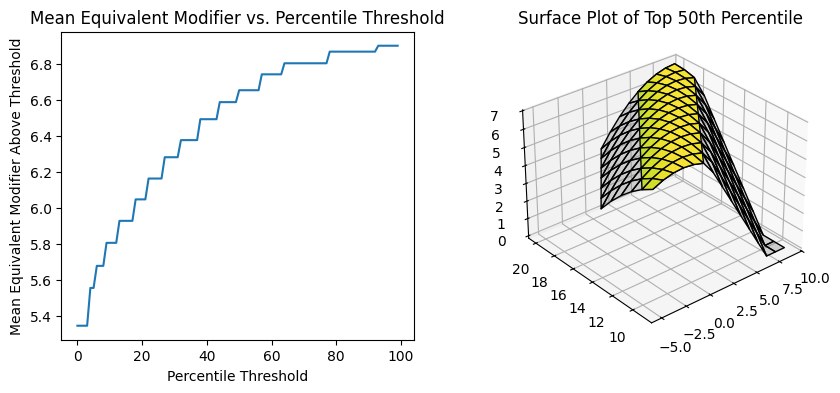

In [356]:
# delete entries past the line connecting (0, 20) and (-6, 14)
mask = dcs_mesh < mods_mesh + 20
em_cleaned = np.where(mask, equivalent_modifiers, np.nan)

def mean_along_ridge(percentile: float):
    threshold = np.nanpercentile(em_cleaned, percentile)
    ridge_mask = em_cleaned >= threshold
    ridge_values = em_cleaned[ridge_mask]
    ridge_mean = ridge_values.mean()
    return threshold, ridge_mask, ridge_mean

mean_by_percentiles = [mean_along_ridge(p) for p in range(0, 100)]

fig = plt.figure(figsize=(10, 4))
gs = GridSpec(1, 2, figure=fig)

ax1 = plt.subplot(gs[0])
percentiles = np.arange(0, 100)
means = [mean for _, _, mean in mean_by_percentiles]
ax1.plot(percentiles, means, marker='')
ax1.set_xlabel('Percentile Threshold')
ax1.set_ylabel('Mean Equivalent Modifier Above Threshold')
ax1.set_title('Mean Equivalent Modifier vs. Percentile Threshold')

threshold_50, ridge_mask_50, ridge_mean_50 = mean_by_percentiles[50]
ax2 = plt.subplot(gs[1], projection='3d')
ax2.plot_surface(mods_mesh, dcs_mesh, em_cleaned, color='lightgrey', edgecolor='k', alpha=0.3)
color_plot = np.where(ridge_mask_50, em_cleaned, np.nan)
ax2.plot_surface(mods_mesh, dcs_mesh, color_plot, cmap=surf.cmap, norm=surf.norm, edgecolor='k', alpha=0.9)
ax2.view_init(azim=-130)
ax2.set_title('Surface Plot of Top 50th Percentile')

plt.show()

In [357]:
print(f"Expected Equivalent Modifier Increase given by Advantage; {ridge_mean_50:.4f} ± {em_cleaned[ridge_mask_50].std():.4f}")

Expected Equivalent Modifier Increase given by Advantage; 6.6531 ± 0.2630


## Additional: Showing that the ridge corresponds to common combat encounters.

Looking at the DC value that gives the maximum edge to advantaged rolls for every modifier, we have a table below mapping a +2 modifier to a simple DC 13 monster, and a +9 modifier to a late-game DC 20 monster. This is pretty much what we expect, since both the modifiers and DC of monsters faced increase as players gain experience and level up.

Ridge line approximation: DC = 0.86 * Modifier + 11.67
[-5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9]
[np.int64(9), np.int64(9), np.int64(9), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)]


Text(0.5, 1.0, 'Ideal DC by Modifier')

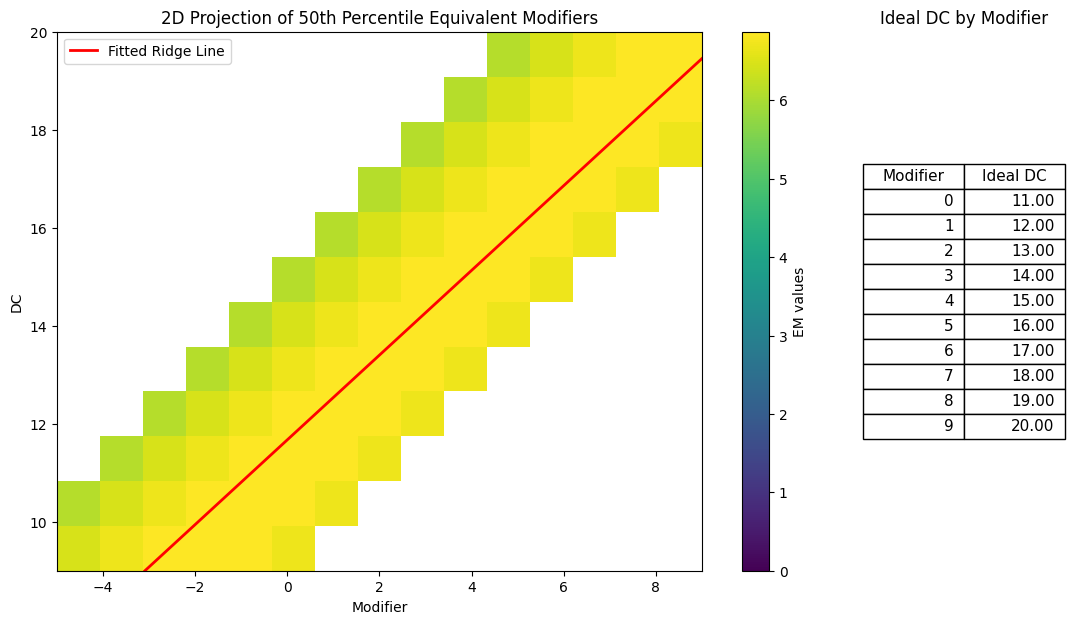

In [ ]:
# Interpolate z along the ridge line
# For each unique modifier, pick the dc with max z
ridge_mods = mods_mesh[ridge_mask_50]
ridge_dcs = dcs_mesh[ridge_mask_50]
ridge_z = equivalent_modifiers[ridge_mask_50]

unique_mods = np.unique(ridge_mods)
dc_at_max_z = [ridge_dcs[ridge_mods==m][np.argmax(ridge_z[ridge_mods==m])] for m in unique_mods]
coef = np.polyfit(unique_mods, dc_at_max_z, 1)
a, b = coef
print(f"Ridge line approximation: DC = {a:.2f} * Modifier + {b:.2f}")

fig = plt.figure(figsize=(13, 7))
gs = GridSpec(1, 2, width_ratios=[4, 1], wspace=0)

ax_plot = fig.add_subplot(gs[0])
color_plot = np.where(ridge_mask, em_cleaned, np.nan)
im = ax_plot.imshow(
    color_plot.T,
    origin='lower',
    extent=[mods.min(), mods.max(), dcs.min(), dcs.max()],
    cmap=surf.cmap,
    norm=surf.norm,
    aspect='auto'
)
fig.colorbar(im, ax=ax_plot, label='EM values')
mod_vals = np.linspace((dcs.min() - b) / a, mods.max(), 100)
ax_plot.plot(mod_vals, a * mod_vals + b, color='red', linewidth=2, label='Fitted Ridge Line')
ax_plot.set_xlabel('Modifier')
ax_plot.set_ylabel('DC')
ax_plot.set_title('2D Projection of 50th Percentile Equivalent Modifiers')
ax_plot.legend(loc='upper left')

ax_table = fig.add_subplot(gs[1])
ax_table.axis('off')
table_data = [[m, f"{dc:.2f}"] for m, dc in zip(range(0, 10), dc_at_max_z[-10:])]
table = ax_table.table(
    cellText=table_data,
    colLabels=['Modifier', 'Ideal DC'],
    loc='center'
)
table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(11)

ax_table.set_title('Ideal DC by Modifier')
